In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CNN - Fire Image Classification

In [2]:
from models.FireDetectionModelFactory import FireDetectionModelFactory

model_name = "efficientnet"
num_classes = 1
to_train = 3

model = FireDetectionModelFactory.create_model(model_name, num_classes, to_train)
model

EfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_ac

## Dataset of images

In [3]:
# Per semplicità in questo caso uso trasforms di torchvision
from torchvision import transforms

preprocessing = model.preprocessing

augmentation = transforms.RandomApply([
    transforms.RandomHorizontalFlip(p=0.3), # Flip orizzontale casuale con probabilità 0.3
    transforms.RandomRotation(degrees=15), # Rotazione casuale entro 30 gradi
    transforms.ColorJitter(hue=0.1, saturation=0.0, brightness=0.0), # Cambia il colore di base dell'immagine con un'intensità massima di ±0.1 per l'asse dell'intonazione
], p=0.7) # Applica le trasformazioni precedenti con probabilità 0.7

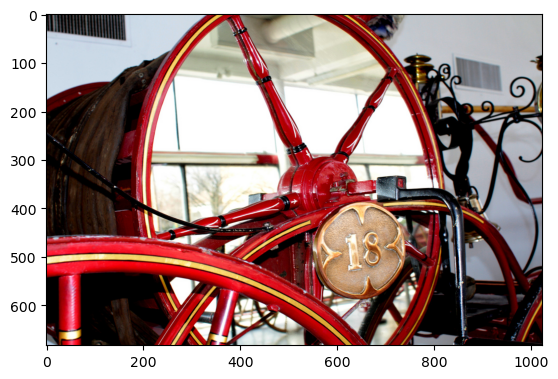

In [4]:
# apply augmentation to a sample image
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("../data/IMAGES/0/not_fire091.png")
img = augmentation(img)
plt.imshow(img)


In [5]:
from pathlib import Path

images_folder = Path("../data/IMAGES")

In [6]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(images_folder, transform=transforms.Compose([preprocessing, augmentation]))
classes = dataset.classes

In [7]:
from torch.utils.data import random_split
import os

rand_bytes = os.urandom(8) # generate 8 random bytes (64 bits) beacuse manual_seed needs a 64-bit integer (8 bytes)
rand_int = int.from_bytes(rand_bytes, byteorder='big')
train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.75, 0.15, 0.10], generator=torch.Generator().manual_seed(rand_int))

In [8]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(170, 34, 22)

# Training CNN

In [9]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import os

def start_tensorboard(log_dir):
  writer = SummaryWriter(os.path.join("runs", log_dir))

  # run tensorboard in background
  ! killall tensorboard
  %load_ext tensorboard
  %tensorboard --logdir ./runs

  notebook.list() # View open TensorBoard instances

  return writer

In [10]:
from torchvision.utils import make_grid
from tqdm import tqdm

def one_epoch(model, lossFunction, output_activation, optimizer, train_loader, val_loader, writer, epoch_num):
  model.to(device)

  model.train()

  i_start = epoch_num * len(train_loader)
  for i, (X, y) in tqdm(enumerate(train_loader), desc="epoch {} - train".format(epoch_num)):

    X = X.to(device)
    y = y.to(device).float()

    optimizer.zero_grad()

    o = model(X)
    o = output_activation(o).squeeze()
    l = lossFunction(o, y)

    l.backward()
    optimizer.step()

    acc = ((o.detach() > .5) == y.detach()).float().mean()
    
    # print("- batch loss and accuracy : {:.7f}\t{:.4f}".format(l.detach().item(), acc))
    writer.add_scalar('train/loss', l.detach().item(), i_start+i)
    writer.add_scalar('train/acc', acc, i_start+i)

  model.eval()
  with torch.no_grad():
    val_loss = []
    val_corr_pred = []
    for X, y in tqdm(val_loader, desc="epoch {} - validation".format(epoch_num)):
      X = X.to(device)
      y = y.to(device).float()

      o = model(X)
      o = output_activation(o).squeeze()
      val_loss.append(lossFunction(o, y))
      val_corr_pred.append((o > .5) == y)

    val_loss = torch.stack(val_loss).mean().item()
    val_accuracy = torch.concatenate(val_corr_pred).float().mean().item()

    # print("Validation loss and accuracy : {:.7f}\t{:.4f}".format(val_loss, val_accuracy))
    writer.add_scalar('val/loss', val_loss, i_start+i)
    writer.add_scalar('val/acc', val_accuracy, i_start+i)
  return val_loss, val_accuracy

In [11]:
from torch.nn import BCELoss, Sigmoid
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau

# learning parameters
lossFunction, output_activation = BCELoss(), Sigmoid()
batch_size = 64
lr = .001
momentum = .9
lambda_reg = 0

epochs = 600
early_stopping_patience = 10

model = FireDetectionModelFactory.create_model(model_name, num_classes, to_train)
# optimizer = torch.optim.Adam(model.get_trainable_parameters(),
#                           lr=lr,
#                           weight_decay=lambda_reg)
optimizer = torch.optim.SGD(model.get_trainable_parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=lambda_reg)

# Creazione dello scheduler ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)
scheduler = None

# create output directory and logger
name = model_name+"_"+datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_name = os.path.join("experiments", name)

In [12]:
import os
os.makedirs(experiment_name)
writer = start_tensorboard(name)
!reload_ext tensorboard

"killall" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


Reusing TensorBoard on port 6006 (pid 10104), started 2 days, 9:02:48 ago. (Use '!kill 10104' to kill it.)

Known TensorBoard instances:
  - port 6006: logdir ./runs (started 2 days, 9:02:48 ago; pid 10104)
  - port 6006: logdir ./runs (started 7 days, 2:57:32 ago; pid 41756)


"reload_ext" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [13]:
from torch.utils.data import DataLoader

dataloader_params = {"batch_size": batch_size, "num_workers": 0, "pin_memory": True}
train_loader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
val_loader = DataLoader(valid_dataset, shuffle=False, **dataloader_params)

In [ ]:
if device.type == "cuda":
  torch.cuda.empty_cache() # pulisce la memoria di cuda

# early stopping and best model saving
early_stopping_counter = early_stopping_patience
min_val_loss = 1e10

# training and validation
val_losses = torch.zeros(epochs)
val_accuracies = torch.zeros(epochs)
for e in range(epochs):
  print("EPOCH {}".format(e))
  val_loss, val_accuracy = one_epoch(model, lossFunction, output_activation, optimizer, train_loader, val_loader, writer, e)

  # store the validation metrics
  val_losses[e] = val_loss
  val_accuracies[e] = val_accuracy
  torch.save(val_losses, os.path.join(experiment_name,'val_losses.pth'))
  torch.save(val_accuracies, os.path.join(experiment_name,'val_accuracies.pth'))

  # save the best model and check the early stopping criteria
  if val_loss < min_val_loss: # save the best model
    min_val_loss = val_loss
    early_stopping_counter = early_stopping_patience # reset early stopping counter
    torch.save(model.state_dict(), os.path.join(experiment_name,'best_model.pth'))
    print("- saved best model: val_loss =", val_loss, "val_accuracy =", val_accuracy)

  if e>0: # early stopping counter update
    if val_losses[e] > val_losses[e-1]:
        early_stopping_counter -= 1 # update early stopping counter
    else:
        early_stopping_counter = early_stopping_patience # reset early stopping counter
  if early_stopping_counter == 0: # early stopping
      break

# Testing

In [ ]:
from torch.utils.data import DataLoader

dataloader_params = {"batch_size": batch_size, "num_workers": 2, "pin_memory": True}
val_loader = DataLoader(test_dataset, shuffle=False, **dataloader_params)

In [ ]:
model = FireDetectionModelFactory.create_model(model_name, num_classes, to_train)
model.load_state_dict(torch.load(os.path.join(experiment_name,'best_model.pth')))
model = model.to(device)

Y, Y_hat = [], []
with torch.no_grad():
  model.eval()
  for X, y in val_loader:
    Y.append(y)
    X = X.to(device)
    Y_hat.append((output_activation(model(X)) > .5).squeeze().cpu())

Y = torch.concatenate(Y).to("cpu")
Y_hat = torch.concatenate(Y_hat).to("cpu")
print("Test accuracy:", (Y==Y_hat).float().mean().item())

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
cm = confusion_matrix(Y, Y_hat)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Fire', 'Fire'])
ax.yaxis.set_ticklabels(['No Fire', 'Fire'])
plt.show()

In [ ]:
# Compute precision and recall and F-score
from sklearn.metrics import precision_score, recall_score
precision = precision_score(Y, Y_hat)
recall = recall_score(Y, Y_hat)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F-score: {:.4f}".format(2 * precision * recall / (precision + recall)))

# CNN + LSTM - Video Fire Classification

Usando i pesi ottenuti nel precedente esprimento, creiamo un modello composto da CNN ed LSTM/GRU + degli strati densi per la classificazione finale.

In [16]:
model = FireDetectionModelFactory.create_model(model_name, num_classes, to_train)
model.load_state_dict(torch.load(os.path.join("experiments\\efficientnet_20230712-003310",'best_model.pth')))

<All keys matched successfully>